In [ ]:
pip install scikit-learn tensorflow torch torchvision matplotlib


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml #OpenML library is a ML library
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
#Load MNIST Data (Datatset made up of handwriiten text images)
mnist = fetch_openml('mnist_784', version=1) #mnist_784 is the name of the dataset on OpenML.
X, y = mnist.data / 255.0, mnist.target.astype(int)  # Normalize
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Scikit-learn Logistic Regression
clf = LogisticRegression(max_iter=1000) #max iteration 1000 to find the best weight
clf.fit(X_train, y_train) #Trains the Logistic Regression model, X_train is training on flattened images; y_train is training on lables
y_pred_sklearn = clf.predict(X_test) #Asks the trained model to guess the digits for the test images
sklearn_accuracy = accuracy_score(y_test, y_pred_sklearn)
print("Scikit-learn Accuracy:", sklearn_accuracy)

Scikit-learn Accuracy: 0.9202142857142858


In [ ]:
#TensorFlow Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# Define model with Dropout + L2 regularization
tf_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(784,),
                          kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),  # randomly turn off 30% neurons

    tf.keras.layers.Dense(64, activation='relu',
                          kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile
tf_model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Early stopping (monitor validation loss)
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           restore_best_weights=True)

# Train model with validation + early stopping
history = tf_model.fit(X_train, y_train,
                       epochs=20,   # keep high, early stopping will stop at the best point
                       batch_size=32,
                       verbose=1,
                       validation_data=(X_test, y_test),
                       callbacks=[early_stop])

# Evaluate
tf_loss, tf_acc = tf_model.evaluate(X_test, y_test, verbose=0)
print("TensorFlow Accuracy:", tf_acc)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7945 - loss: 0.8657 - val_accuracy: 0.9494 - val_loss: 0.3315
Epoch 2/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9306 - loss: 0.3905 - val_accuracy: 0.9566 - val_loss: 0.2833
Epoch 3/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9408 - loss: 0.3401 - val_accuracy: 0.9584 - val_loss: 0.2701
Epoch 4/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9449 - loss: 0.3111 - val_accuracy: 0.9634 - val_loss: 0.2474
Epoch 5/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9481 - loss: 0.3026 - val_accuracy: 0.9629 - val_loss: 0.2494
Epoch 6/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9496 - loss: 0.2933 - val_accuracy: 0.9655 - val_loss: 0.2370
Epoch 7/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9506 - loss: 0.2859 - val_accuracy: 0.9675 - val_loss: 0.2271
Epoch 8/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9531 - loss: 0.

In [ ]:
#PyTorch Model
#Converting Pandas data to PyTorch tensors
X_train_torch = torch.tensor(X_train.values, dtype=torch.float32) #torch.float32 → for features (X_train), because pixel intensities are numbers with decimals.
y_train_torch = torch.tensor(y_train.values, dtype=torch.long) #torch.long → for labels (y_train), because class labels must be integers for classification.
X_test_torch = torch.tensor(X_test.values, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_torch, y_train_torch) #Combines features (X_train_torch) and labels (y_train_torch) into one dataset.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #splitting into 32 no batches and Shuffling the data each epoch so the model doesn’t learn the order of the samples.

In [ ]:
class Net(nn.Module): #Every PyTorch model is a subclass of nn.Module and we are to create own model by creating a class that inherits from nn.Module
    def __init__(self):
        super(Net, self).__init__() #initializes the base nn.Module. self is just a reference to the current object (instance) of the class which is used to store the value of object.
        self.fc1 = nn.Linear(784, 128) #nn.Linear(in_features, out_features) → fully connected (dense) layer. Takes 784 inputs (28×28 pixels flattened) → outputs 128 features.
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
#Forward pass (how input data flows through the network):
    def forward(self, x):
        x = torch.relu(self.fc1(x)) #self.fc1(x) → multiply inputs by weights + bias → apply ReLU activation.. to teach model complex patterns
        x = torch.relu(self.fc2(x)) #self.fc2(x) → again pass through fully connected + ReLU.
        x = self.fc3(x) #self.fc3(x) → final layer outputs raw values (logits) for 10 classes.
        return x

In [ ]:
model = Net() #creates an instance of that network. Now 'model' is a trainable neural network. Net(nn.Module) is our prev neural network with layers
#the optimizer + loss function work together:
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss is used for classification problems.
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5):   # train for 5 epochs
    for batch_X, batch_y in train_loader:   # dataset is split into small batches (32 samples each). Each batch goes through the model.
        optimizer.zero_grad()              # reset previous gradients. clears old gradients (otherwise they add up).
        outputs = model(batch_X)           # forward pass (predict)
        loss = criterion(outputs, batch_y) # calculates error using CrossEntropyLoss
        loss.backward()                    # backpropagation: compute gradients
        optimizer.step()                   # update weights using Adam optimizer. Adjusts the model weights slightly to reduce the loss.
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item():.4f}")


with torch.no_grad():   # no gradient calculation during testing thus saves memory & time
    outputs = model(X_test_torch)         # forward pass on test set
    _, predicted = torch.max(outputs, 1)  # pick class with highest score. _ ignores max scores & Keeps predicted class index
    accuracy = (predicted == y_test_torch).sum().item() / y_test_torch.size(0)
print("PyTorch Accuracy:", accuracy)


Epoch [1/5], Loss: 0.1274
Epoch [2/5], Loss: 0.2556
Epoch [3/5], Loss: 0.0384
Epoch [4/5], Loss: 0.0408
Epoch [5/5], Loss: 0.0232
PyTorch Accuracy: 0.9705714285714285


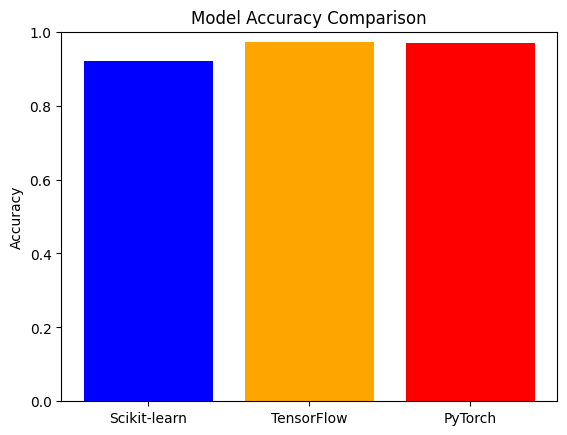

In [ ]:
libraries = ["Scikit-learn", "TensorFlow", "PyTorch"]
accuracies = [sklearn_accuracy, tf_acc, accuracy]

plt.bar(libraries, accuracies, color=["blue", "orange", "red"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()

# **Primary Process**

Load & Prepare Data

1.   Load dataset, split into train/test.

2. Preprocess (normalize, reshape, etc.).


Define Model

1. Choose algorithm/architecture (Logistic Regression, Neural Net, CNN, etc.).

Define Loss Function + Optimizer

1. Loss: measures how wrong predictions are.

2. Optimizer: updates weights to reduce loss.

Train Model

1. Loop through data (epochs, batches).

2. Forward pass → Loss → Backpropagation → Update weights.

Evaluate Model

1. Test on unseen data.

2. Get accuracy, precision, etc.

# **Loss & Accuracy Curves**

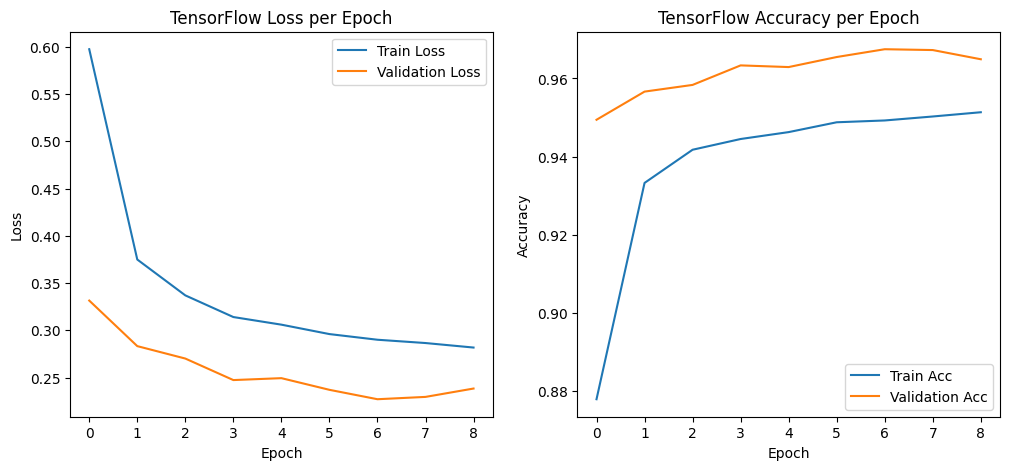

In [ ]:
#TensorFlow
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("TensorFlow Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.title("TensorFlow Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

1. If Train Loss (how well the model is learning from the training data.) ↓ and Validation Loss (computed after each epoch) ↓ = Model is learning well, not overfitting.



2. If Train Loss ↓ but Val Loss ↑ = Overfitting (model memorizing training data, not generalizing).

3. If Train Loss ↑ and Val Loss ↑ = Model is underfitting (not learning enough).

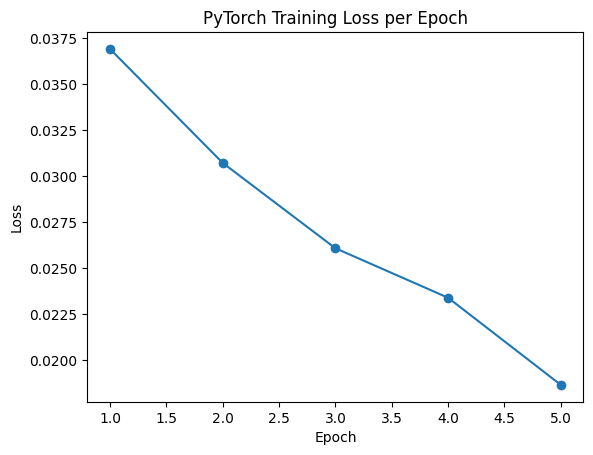

In [17]:
#PyTorch Training graph
pytorch_train_loss = []
for epoch in range(5):
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    pytorch_train_loss.append(running_loss / len(train_loader))

plt.plot(range(1, 6), pytorch_train_loss, marker='o')
plt.title("PyTorch Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


## Confusion Matrix

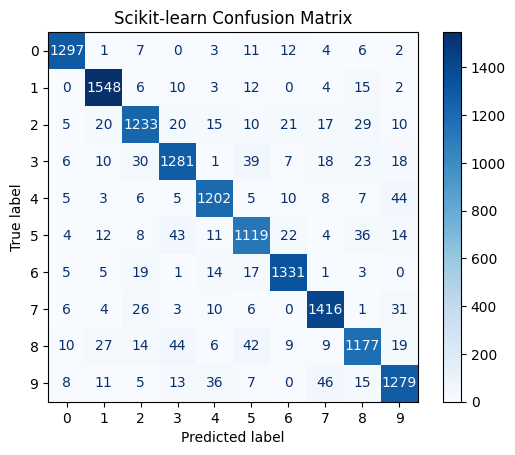

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Scikit-learn Confusion Matrix
y_pred_sklearn = clf.predict(X_test)   # assuming clf is your sklearn model
cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)
ConfusionMatrixDisplay(cm_sklearn).plot(cmap="Blues")
plt.title("Scikit-learn Confusion Matrix")
plt.show()


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


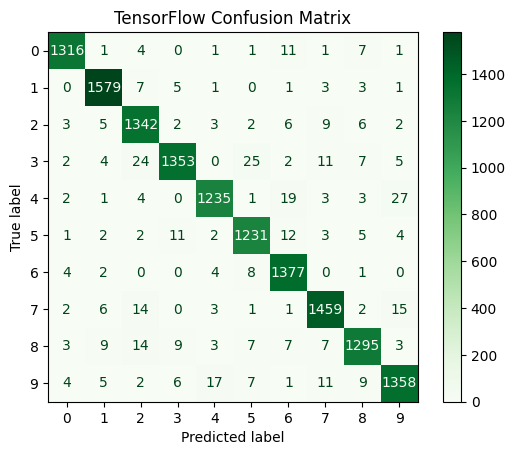

In [19]:
# TensorFlow Confusion Matrix
y_pred_tf = tf_model.predict(X_test).argmax(axis=1)
cm_tf = confusion_matrix(y_test, y_pred_tf)
ConfusionMatrixDisplay(cm_tf).plot(cmap="Greens")
plt.title("TensorFlow Confusion Matrix")
plt.show()

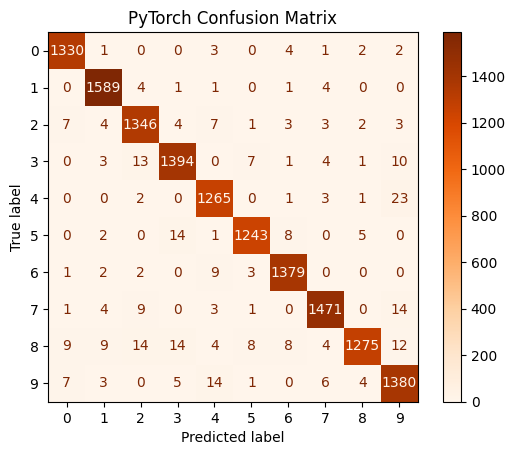

In [20]:
# PyTorch Confusion Matrix
with torch.no_grad():
    outputs = model(X_test_torch)
    _, y_pred_torch = torch.max(outputs, 1)

cm_torch = confusion_matrix(y_test, y_pred_torch.numpy())
ConfusionMatrixDisplay(cm_torch).plot(cmap="Oranges")
plt.title("PyTorch Confusion Matrix")
plt.show()

# **Sample Predictions Gallery**

Show true vs predicted labels with some test images.

In [28]:
sample_images = X_test[:10].to_numpy().reshape(-1, 28, 28)  # reshape MNIST
true_labels = y_test[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


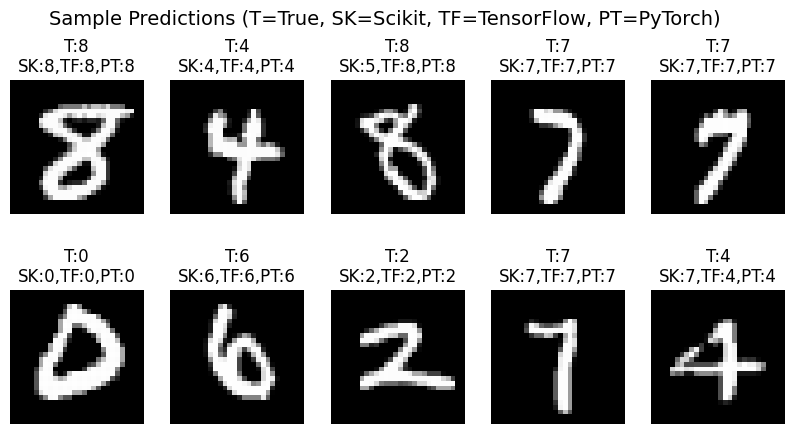

In [29]:
# Scikit-learn predictions
y_pred_sklearn = clf.predict(X_test[:10])

# TensorFlow predictions
y_pred_tf = tf_model.predict(X_test[:10]).argmax(axis=1)

# PyTorch predictions
with torch.no_grad():
    y_pred_torch = model(torch.tensor(X_test[:10].to_numpy(), dtype=torch.float32))
    y_pred_torch = torch.argmax(y_pred_torch, dim=1).numpy()

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(sample_images[i], cmap="gray")
    plt.title(f"T:{true_labels.iloc[i]}\nSK:{y_pred_sklearn[i]},TF:{y_pred_tf[i]},PT:{y_pred_torch[i]}")
    plt.axis("off")
plt.suptitle("Sample Predictions (T=True, SK=Scikit, TF=TensorFlow, PT=PyTorch)", fontsize=14)
plt.show()